## Imports & Load Data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
import researchpy as rp
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
df = pd.read_csv('step0_results.csv', na_values=['no info', '.'], delimiter=',')

## Prepare Table for Statistical Analysis

In [3]:
new_columns = ['date']

for i in range(1, 10):
    for j in range(1, 13):
        new_columns.append(str(i)+str(j))

new_columns.append('feedback')
df.columns = new_columns
df.drop(['date', 'feedback'], axis=1, inplace=True)

In [4]:
df.replace('Strongly disagree', 1, inplace=True)
df.replace('Disagree', 2, inplace=True)
df.replace('Neutral', 3, inplace=True)
df.replace('Agree', 4, inplace=True)
df.replace('Strongly Agree', 5, inplace=True)

df.replace('< 5 min', 1, inplace=True)
df.replace('5 - 15 min', 2, inplace=True)
df.replace('15 - 30 min', 3, inplace=True)
df.replace('30 - 60 min', 4, inplace=True)
df.replace('> 60 min', 5, inplace=True)

In [5]:
# multiplication of values with 1 or -1 depending on the question effect
for column in df:
    r = int(column)%10
    if r == 7 or r == 8 or r == 9 or r == 0:
        #df[column] = df[column]*(-1) # for having negative effect of question
        df[column] = 6 - df[column]

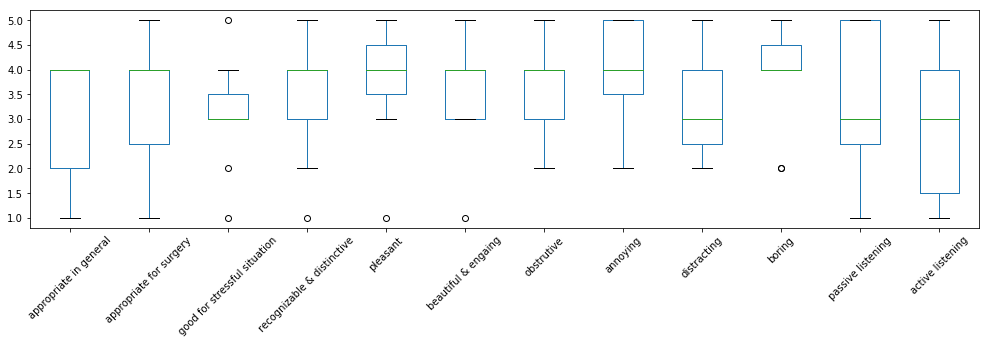

In [41]:
input_boxplot_nature_three = df.iloc[:, 24:36]
input_boxplot_nature_three.columns = ['appropriate in general', 'appropriate for surgery', 
                                      'good for stressful situation', 'recognizable & distinctive', 
                                      'pleasant', 'beautiful & engaing', 'obstrutive', 'annoying', 
                                      'distracting', 'boring', 'passive listening', 'active listening']
boxplot_nature_three = input_boxplot_nature_three.boxplot(column=['appropriate in general', 'appropriate for surgery', 
                                      'good for stressful situation', 'recognizable & distinctive', 
                                      'pleasant', 'beautiful & engaing', 'obstrutive', 'annoying', 
                                      'distracting', 'boring', 'passive listening', 'active listening'], 
                                                          rot=45,
                                                          grid=False, 
                                                          figsize=(17, 4))


## Sum Points Over Questions

In [7]:
sumOverAll = np.nan
sumOverAll = df.sum(axis = 0)
#sumOverAll

In [8]:
sum_over_q = np.empty([1,9], dtype=int)

for i in range(9):
    sum_over_q[0,i] = sumOverAll[i*12:(i*12)+12].sum(axis=0)

In [9]:
sum_over_questions_per_son = pd.DataFrame(sum_over_q, columns=['1', '2', '3', '4', '5', '6', '7', '8', '9'])
sum_over_questions_per_son

,1,2,3,4,5,6,7,8,9
0,377,336,455,425,428,411,445,444,417


In [10]:
qs = np.empty([1,len(df.columns)], dtype=int)

for i in range(len(df.columns)):
    qs[:,i] = df.iloc[:,i].sum()
qs

array([[32, 30, 26, 30, 35, 34, 35, 40, 33, 40, 26, 16, 31, 21, 22, 30,
        31, 29, 32, 34, 29, 40, 21, 16, 33, 36, 34, 38, 42, 39, 40, 44,
        37, 43, 38, 31, 40, 39, 35, 41, 32, 29, 39, 42, 40, 42, 24, 22,
        38, 38, 31, 42, 32, 36, 41, 41, 38, 42, 27, 22, 38, 37, 34, 39,
        30, 28, 37, 36, 41, 43, 26, 22, 36, 31, 34, 34, 43, 40, 40, 47,
        38, 45, 32, 25, 36, 30, 36, 35, 41, 38, 41, 46, 38, 44, 31, 28,
        33, 26, 32, 35, 36, 34, 39, 46, 39, 45, 32, 20]])

## ANOVA

In [11]:
input_for_anova = np.empty([9, 10], dtype=int)

for i in range(9):
    for j in range(10):
        input_for_anova[i, j] = df.iloc[j, i*12:(i*12)+12].sum(axis=0)

ones = [1,1,1,1,1,1,1,1,1,1]
twos = [2,2,2,2,2,2,2,2,2,2]
threes = [3,3,3,3,3,3,3,3,3,3]
group = np.concatenate((np.asarray(ones), np.asarray(twos), np.asarray(threes)), axis=0)

input_for_anova

array([[40, 28, 42, 23, 33, 41, 30, 36, 32, 45],
       [38, 28, 31, 22, 37, 39, 43, 29, 25, 20],
       [47, 28, 38, 36, 44, 58, 42, 39, 30, 47],
       [26, 28, 41, 42, 42, 31, 42, 35, 39, 47],
       [28, 28, 36, 45, 39, 26, 42, 40, 40, 50],
       [24, 28, 31, 39, 34, 38, 38, 40, 39, 50],
       [44, 28, 47, 38, 49, 46, 46, 29, 29, 43],
       [45, 28, 48, 44, 51, 44, 34, 32, 24, 48],
       [51, 28, 36, 29, 42, 39, 40, 38, 35, 34]])

### ANOVA for Nature

In [12]:
input_for_anova_nature = pd.DataFrame(data=input_for_anova[0:3,])
input_for_anova_nature = np.transpose(input_for_anova_nature)
anova_nature = input_for_anova_nature[0].append(input_for_anova_nature[1]).append(input_for_anova_nature[2]).reset_index(drop=True)
nature = pd.DataFrame(data={'effect': anova_nature, 'group': group})

In [13]:
results_nature = ols('effect ~ C(group)', data=nature).fit()
results_nature.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 effect   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     3.829
Date:                Mon, 21 Oct 2019   Prob (F-statistic):             0.0344
Time:                        14:37:22   Log-Likelihood:                -102.99
No. Observations:                  30   AIC:                             212.0
Df Residuals:                      27   BIC:                             216.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        35.0000      2.498     14.012      0.000      29.875      40.125
C(group)[T.2]    -3.8000      3.532     -1.076      0.292     -11.048       3.448
C(group)[T.3]     5.9000      3.532      1.670      0.106      -1.348      13.148
==============================================================================
Omnibus:                        0.555   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.642
Skew:                           0.120   Prob(JB):                        0.726
Kurtosis:                       2.325   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
rp.summary_cont(nature['effect'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,effect,30.0,35.7,8.634933,1.576516,32.475663,38.924337


In [15]:
rp.summary_cont(nature['effect'].groupby(nature['group']))

,N,Mean,SD,SE,95% Conf.,Interval
group,,,,,,
1,10,35.0,7.007932,2.216103,30.421484,39.578516
2,10,31.2,7.771744,2.457641,26.122461,36.277539
3,10,40.9,8.812239,2.786675,35.142671,46.657329


In [16]:
aov_table_nature = sm.stats.anova_lm(results_nature, typ=2)
aov_table_nature

,sum_sq,df,F,PR(>F)
C(group),477.8,2.0,3.829207,0.034355
Residual,1684.5,27.0,NaN,NaN


In [17]:
mc_nature = MultiComparison(nature['effect'], nature['group'])
mc_results_nature = mc_nature.tukeyhsd()
print(mc_results_nature)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  1      2      -3.8   -12.5566  4.9566 False 
  1      3      5.9    -2.8566  14.6566 False 
  2      3      9.7     0.9434  18.4566  True 
----------------------------------------------


#### BONFERRONI CORRECTION POST-HOC COMPARISON

In [18]:
corrected_p_value = 0.05/3
corrected_p_value

0.016666666666666666

In [19]:
stats.ttest_ind(nature['effect'][nature['group'] == 1], nature['effect'][nature['group'] == 2])

Ttest_indResult(statistic=1.1482977237361671, pvalue=0.26587783005821514)

In [20]:
stats.ttest_ind(nature['effect'][nature['group'] == 2], nature['effect'][nature['group'] == 3])

Ttest_indResult(statistic=-2.610626789374613, pvalue=0.017699268598044018)

In [21]:
stats.ttest_ind(nature['effect'][nature['group'] == 1], nature['effect'][nature['group'] == 3])

Ttest_indResult(statistic=-1.6571028959870016, pvalue=0.11482523414441241)

### ANOVA for Algo_Music

In [22]:
input_for_anova_algomus = pd.DataFrame(data=input_for_anova[3:6,])
input_for_anova_algomus = np.transpose(input_for_anova_algomus)
anova_algomus = input_for_anova_algomus[0].append(input_for_anova_algomus[1]).append(input_for_anova_algomus[2]).reset_index(drop=True)
algomus = pd.DataFrame(data={'effect': anova_algomus, 'group': group})

In [23]:
results_algomus = ols('effect ~ C(group)', data=algomus).fit()
results_algomus.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 effect   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.066
Method:                 Least Squares   F-statistic:                   0.09590
Date:                Mon, 21 Oct 2019   Prob (F-statistic):              0.909
Time:                        14:37:22   Log-Likelihood:                -100.98
No. Observations:                  30   AIC:                             208.0
Df Residuals:                      27   BIC:                             212.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        37.3000      2.336     15.967      0.000      32.507      42.093
C(group)[T.2]     0.1000      3.304      0.030      0.976      -6.679       6.879
C(group)[T.3]    -1.2000      3.304     -0.363      0.719      -7.979       5.579
==============================================================================
Omnibus:                        0.932   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.627   Jarque-Bera (JB):                0.830
Skew:                          -0.139   Prob(JB):                        0.660
Kurtosis:                       2.234   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
aov_table_algomus = sm.stats.anova_lm(results_algomus, typ=2)
aov_table_algomus

,sum_sq,df,F,PR(>F)
C(group),10.466667,2.0,0.095901,0.908862
Residual,1473.400000,27.0,NaN,NaN


In [25]:
rp.summary_cont(algomus['effect'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,effect,30.0,36.933333,7.153168,1.305984,34.262296,39.60437


In [26]:
rp.summary_cont(algomus['effect'].groupby(algomus['group']))

,N,Mean,SD,SE,95% Conf.,Interval
group,,,,,,
1,10,37.3,6.961002,2.201262,32.752145,41.847855
2,10,37.4,7.904991,2.499778,32.235406,42.564594
3,10,36.1,7.264067,2.297100,31.354143,40.845857


In [27]:
mc_algomus = MultiComparison(algomus['effect'], algomus['group'])
mc_results_algomus = mc_algomus.tukeyhsd()
print(mc_results_algomus)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2      0.1    -8.0896 8.2896 False 
  1      3      -1.2   -9.3896 6.9896 False 
  2      3      -1.3   -9.4896 6.8896 False 
--------------------------------------------


#### BONFERRONI CORRECTION POST-HOC COMPARISON

In [28]:
stats.ttest_ind(algomus['effect'][algomus['group'] == 1], algomus['effect'][algomus['group'] == 2])

Ttest_indResult(statistic=-0.030022525344182635, pvalue=0.9763794696791193)

In [29]:
stats.ttest_ind(algomus['effect'][algomus['group'] == 2], algomus['effect'][algomus['group'] == 3])

Ttest_indResult(statistic=0.3829238511674655, pvalue=0.7062606774727599)

In [30]:
stats.ttest_ind(algomus['effect'][algomus['group'] == 1], algomus['effect'][algomus['group'] == 3])

Ttest_indResult(statistic=0.3771753589142821, pvalue=0.7104533421565324)

### ANOVA for Japan

In [31]:
input_for_anova_japan = pd.DataFrame(data=input_for_anova[6:9,])
input_for_anova_japan = np.transpose(input_for_anova_japan)
anova_japan = input_for_anova_japan[0].append(input_for_anova_japan[1]).append(input_for_anova_japan[2]).reset_index(drop=True)
japan = pd.DataFrame(data={'effect': anova_japan, 'group': group})

In [32]:
results_japan = ols('effect ~ C(group)', data=japan).fit()
results_japan.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 effect   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.047
Method:                 Least Squares   F-statistic:                    0.3484
Date:                Mon, 21 Oct 2019   Prob (F-statistic):              0.709
Time:                        14:37:22   Log-Likelihood:                -104.12
No. Observations:                  30   AIC:                             214.2
Df Residuals:                      27   BIC:                             218.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        39.9000      2.594     15.385      0.000      34.579      45.221
C(group)[T.2]    -0.1000      3.668     -0.027      0.978      -7.626       7.426
C(group)[T.3]    -2.7000      3.668     -0.736      0.468     -10.226       4.826
==============================================================================
Omnibus:                        2.977   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                1.748
Skew:                          -0.332   Prob(JB):                        0.417
Kurtosis:                       2.021   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
aov_table_japan = sm.stats.anova_lm(results_japan, typ=2)
aov_table_japan

,sum_sq,df,F,PR(>F)
C(group),46.866667,2.0,0.348384,0.708954
Residual,1816.100000,27.0,NaN,NaN


In [34]:
rp.summary_cont(japan['effect'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,effect,30.0,38.966667,8.015,1.463332,35.973816,41.959517


In [35]:
rp.summary_cont(japan['effect'].groupby(japan['group']))

,N,Mean,SD,SE,95% Conf.,Interval
group,,,,,,
1,10,39.9,8.279157,2.618099,34.490951,45.309049
2,10,39.8,9.461031,2.991841,33.618793,45.981207
3,10,37.2,6.613118,2.091252,32.879429,41.520571


In [36]:
mc_japan = MultiComparison(japan['effect'], japan['group'])
mc_results_japan = mc_japan.tukeyhsd()
print(mc_results_japan)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2      -0.1   -9.1923  8.9923 False 
  1      3      -2.7   -11.7923 6.3923 False 
  2      3      -2.6   -11.6923 6.4923 False 
---------------------------------------------


#### BONFERRONI CORRECTION POST-HOC COMPARISON

In [37]:
stats.ttest_ind(japan['effect'][japan['group'] == 1], japan['effect'][japan['group'] == 2])

Ttest_indResult(statistic=0.02515330848901947, pvalue=0.9802094408252287)

In [38]:
stats.ttest_ind(japan['effect'][japan['group'] == 2], japan['effect'][japan['group'] == 3])

Ttest_indResult(statistic=0.7122767899374889, pvalue=0.4854243342346394)

In [39]:
stats.ttest_ind(japan['effect'][japan['group'] == 1], japan['effect'][japan['group'] == 3])

Ttest_indResult(statistic=0.8057806980806286, pvalue=0.43088626012911846)